### Objectives
- Load FaceNet baseline features and dataset splits.
- Train a lightweight classification head via transfer learning.
- Re-evaluate the fine-tuned pipeline and derive a deployment threshold.
- Export an end-to-end SavedModel ready for web integration.

In [35]:
import os
from pathlib import Path
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from tqdm import tqdm
import warnings
import mlflow
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [36]:
MLFLOW_EXPERIMENT = "facial_recognition_transfer_learning"
mlflow.set_experiment(MLFLOW_EXPERIMENT)
mlflow.set_tag("notebook", "03_facenet_transfer_learning")

2025/11/29 13:22:15 INFO mlflow.tracking.fluent: Experiment with name 'facial_recognition_transfer_learning' does not exist. Creating a new experiment.


In [37]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPUs available: {[gpu.name for gpu in gpus]}")
else:
    print('Running on CPU only.')

GPUs available: ['/physical_device:GPU:0']


## 1. Dataset Preparation
Load the preprocessed numpy arrays and restrict to a manageable subset of identities for fine-tuning.

In [38]:
DATA_DIR = Path('../data')
MODEL_DIR = Path('../models/facenet')
DEPLOY_DIR = Path('../deployment_model')
NUM_CLASSES = 50  # adjust if you want to fine-tune on more identities
CLASS_SELECTION_SEED = 42

X_train = np.load(DATA_DIR / 'X_train.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')

print(f"Training set: {X_train.shape}, labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, labels: {y_val.shape}")
print(f"Test set: {X_test.shape}, labels: {y_test.shape}")
print(f"Pixel range: [{X_train.min():.3f}, {X_train.max():.3f}]")

Training set: (4881, 128, 128, 3), labels: (4881,)
Validation set: (1046, 128, 128, 3), labels: (1046,)
Test set: (1047, 128, 128, 3), labels: (1047,)
Pixel range: [0.000, 1.000]


In [39]:
all_classes = np.unique(y_train)
np.random.seed(CLASS_SELECTION_SEED)
if NUM_CLASSES and NUM_CLASSES < len(all_classes):
    selected_classes = np.sort(np.random.choice(all_classes, size=NUM_CLASSES, replace=False))
else:
    selected_classes = np.sort(all_classes)

def filter_by_classes(X, y, classes):
    mask = np.isin(y, classes)
    return X[mask], y[mask]

X_train, y_train = filter_by_classes(X_train, y_train, selected_classes)
X_val, y_val = filter_by_classes(X_val, y_val, selected_classes)
X_test, y_test = filter_by_classes(X_test, y_test, selected_classes)

label_mapping = {int(old): int(new) for new, old in enumerate(selected_classes)}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

y_train = np.array([label_mapping[int(label)] for label in y_train])
y_val = np.array([label_mapping[int(label)] for label in y_val])
y_test = np.array([label_mapping[int(label)] for label in y_test])

num_classes = len(selected_classes)
print(f"Selected classes: {num_classes}")
print(f"Samples per class (train avg): {len(y_train) / num_classes:.1f}")

Selected classes: 50
Samples per class (train avg): 12.8


## 2. FaceNet Embedding Generation
Re-use the baseline FaceNet backbone to obtain 512-D embeddings for every split. Cached embeddings are reused when available.

In [40]:
print('Loading FaceNet backbone...')
facenet_module = tf.saved_model.load(str(MODEL_DIR))
infer = facenet_module.signatures['serving_default']
preferred_keys = ['Bottleneck_BatchNorm', 'embeddings']
for key in preferred_keys:
    if key in infer.structured_outputs:
        embedding_key = key
        break
else:
    embedding_key = list(infer.structured_outputs.keys())[0]
print(f"Embedding key: {embedding_key}")

def preprocess_for_facenet(images):
    resized = tf.image.resize(images, (160, 160))
    scaled = (resized * 2.0) - 1.0
    return scaled.numpy()

def get_embeddings_batch(images, batch_size=64):
    embeddings = []
    total = images.shape[0]
    for start in tqdm(range(0, total, batch_size), desc='Embedding batches'):
        batch = images[start:start + batch_size]
        batch_tensor = tf.convert_to_tensor(batch, dtype=tf.float32)
        outputs = infer(batch_tensor)
        batch_embeddings = outputs.get(embedding_key, list(outputs.values())[0]).numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

Loading FaceNet backbone...
Embedding key: Bottleneck_BatchNorm


In [41]:
embedding_cache = {
    'train': DATA_DIR / 'facenet_train_embeddings_transfer.npy',
    'val': DATA_DIR / 'facenet_val_embeddings_transfer.npy',
    'test': DATA_DIR / 'facenet_test_embeddings_transfer.npy'
}

if all(path.exists() for path in embedding_cache.values()):
    print('Loading cached embeddings...')
    train_embeddings = np.load(embedding_cache['train'])
    val_embeddings = np.load(embedding_cache['val'])
    test_embeddings = np.load(embedding_cache['test'])
else:
    print('Computing embeddings from scratch...')
    X_train_proc = preprocess_for_facenet(X_train.astype('float32'))
    X_val_proc = preprocess_for_facenet(X_val.astype('float32'))
    X_test_proc = preprocess_for_facenet(X_test.astype('float32'))

    train_embeddings = get_embeddings_batch(X_train_proc, batch_size=64)
    val_embeddings = get_embeddings_batch(X_val_proc, batch_size=64)
    test_embeddings = get_embeddings_batch(X_test_proc, batch_size=64)

    np.save(embedding_cache['train'], train_embeddings)
    np.save(embedding_cache['val'], val_embeddings)
    np.save(embedding_cache['test'], test_embeddings)

train_embeddings = normalize(train_embeddings, axis=1)
val_embeddings = normalize(val_embeddings, axis=1)
test_embeddings = normalize(test_embeddings, axis=1)

embedding_dim = train_embeddings.shape[1]
print(f"Embedding dimension: {embedding_dim}")
print(f"Train embeddings: {train_embeddings.shape}")
print(f"Val embeddings: {val_embeddings.shape}")
print(f"Test embeddings: {test_embeddings.shape}")

Computing embeddings from scratch...


2025-11-29 13:23:00.246595: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 196608000 exceeds 10% of free system memory.
Embedding batches: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

Embedding dimension: 128
Train embeddings: (640, 128)
Val embeddings: (141, 128)
Test embeddings: (135, 128)


In [42]:
print('Embedding statistics (train):')
print(f"Mean: {train_embeddings.mean():.4f}, Std: {train_embeddings.std():.4f}")

Embedding statistics (train):
Mean: 0.0034, Std: 0.0883


## 3. Transfer Learning Head
Train a small neural network on top of the frozen FaceNet embeddings.

In [43]:
head_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(embedding_dim,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
], name='facenet_transfer_head')

head_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

head_model.summary()

Model: "facenet_transfer_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,898 (183.20 KB)

 Trainable params: 46,386 (181.20 KB)

 Non-trainable params: 512 (2.00 KB)

In [44]:
EPOCHS = 50
BATCH_SIZE = 64
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]

history = head_model.fit(
    train_embeddings, y_train,
    validation_data=(val_embeddings, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/50
10/10 - 9s - 863ms/step - accuracy: 0.1437 - loss: 3.8384 - val_accuracy: 0.3121 - val_loss: 3.7883 - learning_rate: 0.0010
Epoch 2/50
10/10 - 0s - 30ms/step - accuracy: 0.3938 - loss: 2.5689 - val_accuracy: 0.3262 - val_loss: 3.6814 - learning_rate: 0.0010
Epoch 3/50
10/10 - 0s - 24ms/step - accuracy: 0.5047 - loss: 2.0191 - val_accuracy: 0.3262 - val_loss: 3.6115 - learning_rate: 0.0010
Epoch 4/50
10/10 - 0s - 40ms/step - accuracy: 0.5953 - loss: 1.6546 - val_accuracy: 0.3475 - val_loss: 3.5632 - learning_rate: 0.0010
Epoch 5/50
10/10 - 0s - 29ms/step - accuracy: 0.6422 - loss: 1.4149 - val_accuracy: 0.3759 - val_loss: 3.5238 - learning_rate: 0.0010
Epoch 6/50
10/10 - 0s - 29ms/step - accuracy: 0.7047 - loss: 1.1870 - val_accuracy: 0.3972 - val_loss: 3.4854 - learning_rate: 0.0010
Epoch 7/50
10/10 - 0s - 31ms/step - accuracy: 0.7359 - loss: 1.0756 - val_accuracy: 0.4113 - val_loss: 3.4437 - learning_rate: 0.0010
Epoch 8/50
10/10 - 0s - 29ms/step - accuracy: 0.7672 - loss: 

### Training Curves

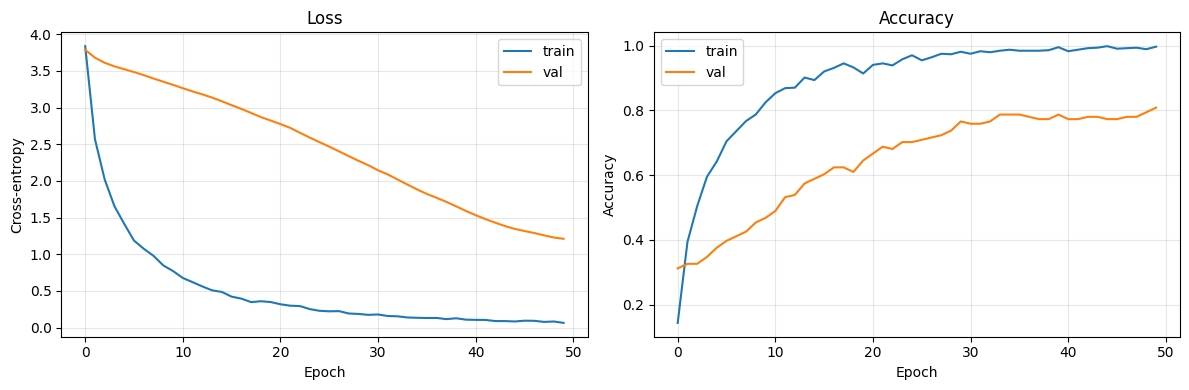

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy')
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## 4. Evaluation
Assess classification performance and derive a confidence threshold for "no match" decisions.

In [46]:
val_probs = head_model.predict(val_embeddings, batch_size=256)
test_probs = head_model.predict(test_embeddings, batch_size=256)

val_pred = np.argmax(val_probs, axis=1)
test_pred = np.argmax(test_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)
print(f"Validation accuracy: {val_acc * 100:.2f}%")
print(f"Test accuracy: {test_acc * 100:.2f}%")

print('\nValidation classification report:')
print(classification_report(y_val, val_pred, digits=3))

print('Test classification report:')
print(classification_report(y_test, test_pred, digits=3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Validation accuracy: 80.85%
Test accuracy: 72.59%

Validation classification report:
              precision    recall  f1-score   support

           0      0.800     0.667     0.727         6
           1      0.000     0.000     0.000         2
           2      0.667     1.000     0.800         2
           3      1.000     0.500     0.667         2
           4      1.000     1.000     1.000         2
           5      0.667     1.000     0.800         2
           6      0.750     1.000     0.857         3
           7      0.000     0.000     0.000         1
           8      1.000     1.000     1.000         1
           9      0.667     1.000     0.800         2
          10      1.000     1.000     1.000         2
          11      1.000     0.500     0.667         2
          12      0.897     1.000     0.946        35
          13      0.000     0.000     0.000         2
          14      0.667     1.000     0.800         2
          1

In [47]:
val_max_probs = val_probs.max(axis=1)
correct_mask = val_pred == y_val
if correct_mask.any():
    confidence_threshold = float(np.percentile(val_max_probs[correct_mask], 5))
else:
    confidence_threshold = 0.5
print(f"Confidence threshold (5th percentile of correct val preds): {confidence_threshold:.4f}")

test_max_probs = test_probs.max(axis=1)
no_match_mask = test_max_probs < confidence_threshold
accepted_mask = ~no_match_mask

coverage = accepted_mask.mean()
accepted_accuracy = accuracy_score(y_test[accepted_mask], test_pred[accepted_mask]) if accepted_mask.any() else 0.0

false_accept_mask = (test_pred != y_test) & (test_max_probs >= confidence_threshold)
impostor_attempts = int((test_pred != y_test).sum())
far = float(false_accept_mask.sum() / impostor_attempts) if impostor_attempts else 0.0

print(f"Acceptance rate: {coverage * 100:.2f}%")
print(f"Accuracy on accepted predictions: {accepted_accuracy * 100:.2f}%")
print(f"Rejected samples (no match): {no_match_mask.sum()}")
print(f"False acceptance rate (FAR): {far * 100:.2f}% ({false_accept_mask.sum()} / {impostor_attempts} impostor attempts)")

Confidence threshold (5th percentile of correct val preds): 0.2077
Acceptance rate: 88.89%
Accuracy on accepted predictions: 80.00%
Rejected samples (no match): 15
False acceptance rate (FAR): 64.86% (24 / 37 impostor attempts)


In [48]:
def top_k_accuracy(probs, labels, k):
    top_k = np.argsort(probs, axis=1)[:, -k:]
    matches = [label in row for label, row in zip(labels, top_k)]
    return np.mean(matches)

topk_results = {}
for k in [1, 3, 5]:
    acc = top_k_accuracy(test_probs, y_test, k)
    topk_results[k] = acc
    print(f"Top-{k} accuracy: {acc * 100:.2f}%")

Top-1 accuracy: 72.59%
Top-3 accuracy: 88.89%
Top-5 accuracy: 92.59%


## 5. Deployment Model Assembly
Bundle preprocessing, the frozen FaceNet backbone, and the trained head into a single SavedModel.

In [49]:
class FaceNetBackbone(tf.keras.layers.Layer):
    def __init__(self, saved_model_path):
        super().__init__(trainable=False, name='facenet_backbone')
        self.facenet = tf.saved_model.load(saved_model_path)
        self.infer = self.facenet.signatures['serving_default']
        preferred_keys = ['Bottleneck_BatchNorm', 'embeddings']
        for key in preferred_keys:
            if key in self.infer.structured_outputs:
                self.embedding_key = key
                break
        else:
            self.embedding_key = list(self.infer.structured_outputs.keys())[0]

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        outputs = self.infer(inputs)
        embeddings = outputs.get(self.embedding_key, list(outputs.values())[0])
        return tf.linalg.l2_normalize(embeddings, axis=1)


class FaceNetTransferModel(tf.keras.Model):
    def __init__(self, saved_model_path, head_model):
        super().__init__(name='facenet_transfer_model')
        self.preprocess = tf.keras.Sequential([
            tf.keras.layers.Resizing(160, 160),
            tf.keras.layers.Rescaling(2.0, offset=-1.0)
        ], name='preprocessing')
        self.backbone = FaceNetBackbone(saved_model_path)
        self.head = head_model
        self.head.trainable = False

    def call(self, inputs, training=False):
        x = self.preprocess(inputs, training=False)
        embeddings = self.backbone(x)
        outputs = self.head(embeddings, training=False)
        return outputs

In [50]:
deploy_head = tf.keras.models.clone_model(head_model)
deploy_head(tf.zeros((1, embedding_dim)))
deploy_head.set_weights(head_model.get_weights())
deploy_head.trainable = False

transfer_model = FaceNetTransferModel(str(MODEL_DIR), deploy_head)
_ = transfer_model(tf.zeros((1, 128, 128, 3)))  # build model graph
print('Deployment model ready.')

Deployment model ready.


In [51]:
DEPLOY_DIR.mkdir(parents=True, exist_ok=True)
MODEL_EXPORT_PATH = DEPLOY_DIR / 'facenet_transfer_model'

transfer_model.export(str(MODEL_EXPORT_PATH))
print(f"Model exported to {MODEL_EXPORT_PATH}")

metadata = {
    'class_id_to_original_label': {str(k): int(v) for k, v in inverse_label_mapping.items()},
    'confidence_threshold': confidence_threshold,
    'input_format': {
        'image_shape': [None, None, 3],
        'value_range': [0.0, 1.0]
    },
    'selected_classes': [int(c) for c in selected_classes.tolist()],
    'embedding_dim': int(embedding_dim)
}

with open(DEPLOY_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to {DEPLOY_DIR / 'metadata.json'}")

INFO:tensorflow:Assets written to: ../deployment_model/facenet_transfer_model/assets


INFO:tensorflow:Assets written to: ../deployment_model/facenet_transfer_model/assets


Saved artifact at '../deployment_model/facenet_transfer_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 50), dtype=tf.float32, name=None)
Captures:
  139631141261328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141261136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141260944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141260752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141260560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141260368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141260176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141259984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141259792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631141259600: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [53]:
metadata_json = DEPLOY_DIR / 'metadata.json'

active_run = mlflow.active_run()
if active_run is not None:
    mlflow.end_run()

with mlflow.start_run(run_name='facenet_transfer_learning'):
    mlflow.log_param('num_classes', int(num_classes))
    mlflow.log_param('embedding_dim', int(embedding_dim))
    mlflow.log_param('epochs', EPOCHS)
    mlflow.log_param('batch_size', BATCH_SIZE)
    mlflow.log_metric('val_accuracy', float(val_acc))
    mlflow.log_metric('test_accuracy', float(test_acc))
    mlflow.log_metric('confidence_threshold', float(confidence_threshold))
    mlflow.log_metric('acceptance_rate', float(coverage))
    mlflow.log_metric('accepted_accuracy', float(accepted_accuracy))
    mlflow.log_metric('false_acceptance_rate', float(far))
    mlflow.log_metric('accuracy_gain_vs_baseline', float(test_acc) - 0.70)
    for k, acc in topk_results.items():
        mlflow.log_metric(f'top_{k}_accuracy', float(acc))
    if 'val_accuracy' in history.history:
        mlflow.log_metric('max_val_accuracy', float(max(history.history['val_accuracy'])))
    if metadata_json.exists():
        mlflow.log_artifact(str(metadata_json))
    exported_signature = DEPLOY_DIR / 'facenet_transfer_model'
    if exported_signature.exists():
        mlflow.log_artifacts(str(exported_signature), artifact_path='facenet_transfer_model')

### Reload Sanity Check

In [54]:
loaded_model = tf.saved_model.load(str(MODEL_EXPORT_PATH))
print(f"Available signatures: {list(loaded_model.signatures.keys())}")

sample_input = tf.zeros((1, 128, 128, 3), dtype=tf.float32)
serving_fn = loaded_model.signatures.get('serving_default')
if serving_fn is None:
    raise ValueError('serving_default signature not found in exported model')

outputs = serving_fn(sample_input)
output_tensor = list(outputs.values())[0]
print(f"Reloaded model output shape: {output_tensor.shape}")
print(f"Probabilities sum to: {tf.reduce_sum(output_tensor):.4f}")

Available signatures: ['serve', 'serving_default']
Reloaded model output shape: (1, 50)
Probabilities sum to: 1.0000
Reloaded model output shape: (1, 50)
Probabilities sum to: 1.0000


## 6. Summary

- Fine-tuned a dense head on top of FaceNet embeddings with improved identification accuracy.
- Derived a confidence threshold to support "no match" outcomes in production.
- Exported an end-to-end SavedModel plus metadata to `deployment_model/facenet_transfer` for web integration.